In [ ]:
# 


In [2]:
import geopandas as gpd
import json
import matplotlib
import matplotlib.cm as cm
import matplotlib.colors as colors
from datetime import timedelta
import matplotlib.pyplot as plt
import networkx as nx
from shapely.geometry import Point
from shapely.geometry import LineString
from shapely.geometry import MultiLineString
import numpy as np
import numpy as npm
import osmnx as ox
import math
import pandas as pd
from shapely.ops import snap
from tqdm import tqdm
import re

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/home/chriscarey/miniconda3/envs/mlc/lib/python3.7/site-packages/geopandas/_compat.py:53: UserWarning: The installed version of PyGEOS is too old (0.5 installed, 0.8 required), and thus GeoPandas will not use PyGEOS.
  UserWarning,


In [3]:
CRS_LATLON = 'EPSG:4326'
DATA_DIR = '../../data'
EXPORTS_DIR = f'{DATA_DIR}/exports'

In [4]:
def peek(df):
    print(len(df))
    display(df.iloc[0:3])

In [5]:
stops_nodes_df = pd.read_csv(f'{EXPORTS_DIR}/csv/manhattan/stops_nodes.csv')
stops_nodes_df = stops_nodes_df.set_index('stop_id')
peek(stops_nodes_df)

1590


,stop_name,stop_lat,stop_lon,M1,M10,M100,M101,M102,M103,M104,...,M5,M50,M55,M57,M66,M7,M72,M8,M9,M96
stop_id,,,,,,,,,,,,,,,,,,,,,
400001,4 AV/E 10 ST,40.731342,-73.990292,POINT (-73.99037 40.73135),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
400002,4 AV/E 12 ST,40.732608,-73.989958,POINT (-73.99006 40.73262),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
400003,4 AV/E 13 ST,40.733936,-73.989720,POINT (-73.98985 40.73394),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
route_ids = list(stops_nodes_df.columns[3:])

In [7]:
def graph_to_node_gdf(G):
    """Converts the given graph to a GeoDataFrame of its nodes."""
    nodes, data = zip(*G.nodes(data=True))
    geom = [Point(node[0], node[1]) for node in nodes]
    nodes_gdf = gpd.GeoDataFrame(data,
                                 index=list(nodes),
                                 crs=CRS_LATLON,
                                 geometry=geom)
    return nodes_gdf

In [8]:
def graph_to_edge_gdf(G):
    """Converts the given graph to a GeoDataFrame of its edges."""
    u, v, data = zip(*G.edges(data=True))
    edges = list(zip(u, v))
    attrs = nx.get_edge_attributes(G, 'speed')
    geom = [
        LineString((Point(edge[0][0],
                          edge[0][1]), Point(edge[1][0], edge[1][1])))
        for edge in edges
    ]
    edge_index = [(edge[0] + edge[1]) for edge in edges]
    edges_gdf = gpd.GeoDataFrame(data,
                                 index=edge_index,
                                 crs=CRS_LATLON,
                                 geometry=list(geom))
    edges_gdf['length'] = edges_gdf.geometry.length
    edges_gdf = edges_gdf.drop(columns={
        'route_shor',
        'route_long',
        'color',
        'ShpName',
        'Wkb',
        'Wkt',
        'Json',
    }, errors='ignore')
    return edges_gdf

In [9]:
def get_node(mg, point):
    threshold = 0.00001
    for node in route_mg.nodes():
        if abs(node[0] - point[0]) < threshold and abs(node[1] - point[1]) < threshold:
            return node
    return None

In [10]:
route_mgs = []

for route_id in route_ids:
    route_mg = nx.read_shp(f'{EXPORTS_DIR}/shp/manhattan/routes/{route_id}.shp', simplify=False)
    route_mg.graph['crs'] = CRS_LATLON
    route_mgs.append(route_mg)

In [11]:
all_routes_mg = route_mgs[0]

for i, route_mg in enumerate(route_mgs[1:]):
    all_routes_mg = nx.compose(all_routes_mg, route_mg)

In [12]:
import pickle
f = open(f'{EXPORTS_DIR}/pkl/avg_speed_attr_dict.pkl', 'rb')
avg_speed_attr_dict = pickle.load(f)
f.close()

In [13]:
f = open(f'{EXPORTS_DIR}/pkl/all_trip_attr_dict.pkl', 'rb')
all_trip_attr_dict = pickle.load(f)
f.close()

In [14]:
nx.set_edge_attributes(all_routes_mg, avg_speed_attr_dict)

In [15]:
all_nodes_gdf = graph_to_node_gdf(all_routes_mg)
all_edges_gdf = graph_to_edge_gdf(all_routes_mg)

In [16]:
edges = ((edge[0], edge[1]) for edge in all_routes_mg.edges(data=True) if 'speeds_0' in edge[2])
speed_mg = all_routes_mg.edge_subgraph(edges)
nx.set_edge_attributes(speed_mg, avg_speed_attr_dict)

In [17]:
speed_edges_gdf = graph_to_edge_gdf(speed_mg)

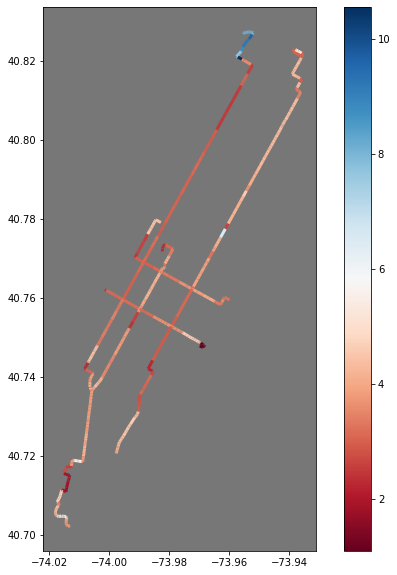

In [18]:
fig, ax = plt.subplots(figsize=(10, 10))
speed_edges_gdf.plot(ax=ax, column='speeds_0', cmap='RdBu', zorder=2, linewidth=3, legend=True)
ax.set_facecolor('#777')

In [19]:
trip_mg = speed_mg
nx.set_edge_attributes(trip_mg, all_trip_attr_dict)
trip_edges_gdf = graph_to_edge_gdf(trip_mg)
trip_edges_gdf = trip_edges_gdf.reset_index()
trip_edges_gdf = trip_edges_gdf.rename(columns={'index': 'edge'})
trip_edges_gdf = trip_edges_gdf.drop(columns=['route_id', 'route_dir', 'speeds_0', 'speeds_1', 'speeds_2', 'geometry', 'length'], errors='ignore')
peek(trip_edges_gdf)

951


,edge,MQ_C1-Weekday-040000_M20_152,MQ_C1-Weekday-042500_M20_151,MQ_C1-Weekday-044500_M20_154,MQ_C1-Weekday-046500_M20_153,MQ_C1-Weekday-048500_M20_156,MQ_C1-Weekday-050500_M20_155,MQ_C1-Weekday-052500_M20_152,MQ_C1-Weekday-055000_M20_157,MQ_C1-Weekday-057500_M20_151,...,MQ_C1-Weekday-131500_M42_320,MQ_C1-Weekday-133400_M42_319,MQ_C1-Weekday-135400_M42_321,MQ_C1-Weekday-137400_M42_320,MQ_C1-Weekday-139400_M42_319,MQ_C1-Weekday-141400_M42_321,MQ_C1-Weekday-144400_M42_320,MQ_C1-Weekday-147400_M42_321,layer,path
0,"(-74.0152, 40.71601, -74.01515, 40.71603)",79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"(-73.97669, 40.76411, -73.97612, 40.76386)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"(-73.97833, 40.78314, -73.97819, 40.78333)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
ip_edges_gdf = speed_edges_gdf.reset_index()
ip_edges_gdf['length'] = ip_edges_gdf['length'] * (0.11 / 0.000001)
ip_edges_gdf['duration_0'] = ip_edges_gdf['length'] / ip_edges_gdf['speeds_0']
ip_edges_gdf['duration_1'] = ip_edges_gdf['length'] / ip_edges_gdf['speeds_1']
ip_edges_gdf['duration_2'] = ip_edges_gdf['length'] / ip_edges_gdf['speeds_2']
ip_edges_gdf['speed_diff'] = ip_edges_gdf['speeds_0'] - (ip_edges_gdf['speeds_1'] + ip_edges_gdf['speeds_2']) / 2
ip_edges_gdf[['duration_0', 'duration_1', 'duration_2']] = ip_edges_gdf[['duration_0', 'duration_1', 'duration_2']].fillna(0)
peek(ip_edges_gdf)

951


,index,route_id,route_dir,speeds_0,speeds_1,speeds_2,layer,path,geometry,length,duration_0,duration_1,duration_2,speed_diff
0,"(-74.0152, 40.71601, -74.01515, 40.71603)",M22,M22_0,2.750121,2.406144,3.033303,NaN,NaN,"LINESTRING (-74.01520 40.71601, -74.01515 40.7...",5.923681,2.153971,2.461898,1.952881,0.030398
1,"(-73.97669, 40.76411, -73.97612, 40.76386)",M57,M57_0,3.666894,1.953036,2.350320,NaN,NaN,"LINESTRING (-73.97669 40.76411, -73.97612 40.7...",68.465612,18.671280,35.055996,29.130340,1.515217
2,"(-73.97833, 40.78314, -73.97819, 40.78333)",M7,M7_0,3.055934,2.446731,2.610859,NaN,NaN,"LINESTRING (-73.97833 40.78314, -73.97819 40.7...",25.960932,8.495253,10.610457,9.943446,0.527139


In [21]:
edge_manifest = ip_edges_gdf[['index', 'speeds_0', 'speeds_1', 'speeds_2', 'length', 'duration_0', 'duration_1', 'duration_2']]
edge_manifest = edge_manifest.rename(columns={'index': 'edge'})
edge_manifest = edge_manifest.merge(trip_edges_gdf, left_on='edge', right_on='edge', how='left')
peek(edge_manifest.iloc[:, 10:])

951


,MQ_C1-Weekday-044500_M20_154,MQ_C1-Weekday-046500_M20_153,MQ_C1-Weekday-048500_M20_156,MQ_C1-Weekday-050500_M20_155,MQ_C1-Weekday-052500_M20_152,MQ_C1-Weekday-055000_M20_157,MQ_C1-Weekday-057500_M20_151,MQ_C1-Weekday-059500_M20_154,MQ_C1-Weekday-061500_M20_158,MQ_C1-Weekday-063500_M20_153,...,MQ_C1-Weekday-131500_M42_320,MQ_C1-Weekday-133400_M42_319,MQ_C1-Weekday-135400_M42_321,MQ_C1-Weekday-137400_M42_320,MQ_C1-Weekday-139400_M42_319,MQ_C1-Weekday-141400_M42_321,MQ_C1-Weekday-144400_M42_320,MQ_C1-Weekday-147400_M42_321,layer,path
0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
def get_start_node(edge):
    return edge[0:2]
def get_end_node(edge):
    return edge[2:]

In [23]:
node_edge_manifest = edge_manifest[['edge']]
node_edge_manifest['start'] = node_edge_manifest['edge'].apply(lambda x: get_start_node(x))
node_edge_manifest['end'] = node_edge_manifest['edge'].apply(lambda x: get_end_node(x))

start_nodes = list(set(node_edge_manifest['start']))
end_nodes = list(set(node_edge_manifest['end']))
nodes = list(set(start_nodes + end_nodes))
node_manifest = pd.DataFrame(nodes)
node_manifest['node'] = node_manifest.apply(lambda x: (x[0], x[1]), axis=1)
node_manifest = node_manifest[['node']]

node_edge_manifest['start'] = node_edge_manifest['start'].apply(lambda x: nodes.index(x))
node_edge_manifest['end'] = node_edge_manifest['end'].apply(lambda x: nodes.index(x))
node_edge_manifest = node_edge_manifest[['start', 'end']]

In [24]:
node_latlon_df = pd.DataFrame(nodes, columns=['lon', 'lat'])
ip_nodes_gdf = gpd.GeoDataFrame({}, geometry=gpd.points_from_xy(node_latlon_df['lon'], node_latlon_df['lat']), crs=CRS_LATLON)

In [25]:
def get_prev_edges(row, manifest):
    start = row['start']
    prev_edges = list(manifest[manifest['end'] == start].index)
    return prev_edges

In [26]:
def get_next_edges(row, manifest):
    end = row['end']
    next_edges = list(manifest[manifest['start'] == end].index)
    return next_edges

In [27]:
edge_node_manifest = node_edge_manifest.reset_index().rename(columns={'index': 'edge'})
edge_node_manifest['prev'] = [[] for i in range(len(edge_node_manifest))]
edge_node_manifest['next'] = [[] for i in range(len(edge_node_manifest))]
edge_node_manifest['prev'] = edge_node_manifest.apply(lambda x: get_prev_edges(x, edge_node_manifest), axis=1)
edge_node_manifest['next'] = edge_node_manifest.apply(lambda x: get_next_edges(x, edge_node_manifest), axis=1)
peek(edge_node_manifest)

951


,edge,start,end,prev,next
0,0,0,361,[265],[408]
1,1,2,184,[398],[204]
2,2,4,913,[371],[916]


In [28]:
prev_edges = list(edge_node_manifest['prev'])
next_edges = list(edge_node_manifest['next'])
start_nodes = list(edge_node_manifest['start'])

In [29]:
def get_trip_df(trip_id):
    trip_df = edge_manifest[[trip_id]]
    trip_df = trip_df.dropna()
    trip_df = trip_df.sort_values(by=[trip_id])
    return trip_df

In [30]:
import gurobipy as gp
from gurobipy import GRB

In [31]:
N_EDGES = len(edge_manifest)
N_NODES = len(node_manifest)
EDGE_POWER_SUPPLY = 80 # kW
EDGE_POWER_DEMAND = 0.003 # kWh/m
EDGE_COST_CABLE = 500 # $/m
NODE_TRANSMITTER_COST = 50000 # $/unit
BATTERY_COST = 800 # $/kWh

In [32]:
cable_costs = list(ip_edges_gdf['length'] * EDGE_COST_CABLE)

edge_power_supplies = [list((ip_edges_gdf[f'duration_{h}'] / 60 / 60) * EDGE_POWER_SUPPLY) for h in range(3)]
edge_power_demands = [list(ip_edges_gdf[f'length'] * EDGE_POWER_DEMAND) for h in range(3)]

power_costs = [.00168, .002384, .002384] # $/kWh

In [33]:
def hash_trip(trip):
    return ','.join([str(x) for x in trip])

In [34]:
trip_ids = list(edge_manifest.columns[10:])
trip_ids
trips = []
trip_hashes = set([])

for trip_id in trip_ids:
    trip_df = get_trip_df(trip_id)
    trip = list(trip_df.index)
    trip_hash = hash_trip(trip)
    if trip_hash not in trip_hashes:
        trips.append(trip)
        trip_hashes.add(trip_hash)
len(trips)

6

In [35]:
HOURS = 3

In [36]:
BATTERY_SIZE = 20 # kWh
print(BATTERY_SIZE)

20


In [37]:
def plot_model(model, ax=None):
    opt_x = model.getAttr('X', model.getVars()[:N_EDGES])
    xdf = pd.DataFrame(opt_x, columns=['x'])
    
    opt_y = model.getAttr('X', model.getVars()[N_EDGES:N_EDGES+N_NODES])
    ydf = pd.DataFrame(opt_y, columns=['y'])
    
    plot_results(xdf, ydf, ax=ax)

In [38]:
def plot_results(xdf, ydf, ax):
    mxdf = ip_edges_gdf.merge(xdf, left_index=True, right_index=True, how='left')
    mxdf.plot(ax=ax, column='x', cmap='Blues', zorder=2, linewidth=3)
    
    mydf = ip_nodes_gdf.merge(ydf, left_index=True, right_index=True, how='left')
    mydf = mydf[mydf['y'] == 1]
    mydf.plot(ax=ax, color='C1', zorder=3, markersize=30)
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax.set_facecolor('#777')

In [39]:
TRIPS_PER_INTERVAL = 8 

In [61]:
def create_model(name, power_costs=power_costs, node_transmitter_cost=NODE_TRANSMITTER_COST, battery_size=BATTERY_SIZE):
    model = gp.Model(name)

    x = model.addVars(N_EDGES, vtype=GRB.BINARY)
    y = model.addVars(N_NODES, vtype=GRB.BINARY)
    z = model.addVars(len(trips), vtype=GRB.BINARY)
    b = model.addVar(vtype=GRB.CONTINUOUS, lb=10, ub=100)

    for k, trip in enumerate(trips):
        for h in range(3):
            power = np.sum([edge_power_supplies[h][i] for i in trip])
            power_supplied = np.sum([edge_power_supplies[h][i] for i in trip])
            power_demanded = np.sum([edge_power_demands[h][i] for i in trip])
            battery = b
            BATTERY_MAX = battery_size
            BATTERY_MIN = BATTERY_MAX * 0.1
            
            #display(f'supply: {power_supplied}, demand: {power_demanded}')

            for j in range(1, len(trip)):
                net_power = gp.quicksum(-edge_power_demands[h][i] + x[i] * edge_power_supplies[h][i] for i in trip[0:j]) * TRIPS_PER_INTERVAL
                model.addConstr(battery + net_power * z[k] >= BATTERY_MIN)
                model.addConstr(battery + net_power * z[k] <= BATTERY_MAX * TRIPS_PER_INTERVAL)

            for j in trip:
                transmitter = y[start_nodes[j]]
                prev_cable = gp.quicksum(x[i] for i in prev_edges[j])
                model.addConstr(x[j] <= transmitter + prev_cable)

    model.addConstr(gp.quicksum(y[start_nodes[i]] * x[i] for i in range(N_EDGES)) == y.sum())
    model.addConstr(z.sum() >= len(trips))

    cable_cost = gp.quicksum((x[i] * cable_costs[i]) for i in range(N_EDGES))
    transmitter_cost = gp.quicksum((y[i] * node_transmitter_cost) for i in range(N_NODES))
    power_cost = gp.quicksum(edge_power_supplies[h][i] * TRIPS_PER_INTERVAL * x[i] * power_costs[h] for h in range(3) for i in range(N_EDGES)) * 365 * 10 
    battery_cost = b * BATTERY_COST

    objective = cable_cost + transmitter_cost + power_cost + battery_cost
    model.setObjective(objective, GRB.MINIMIZE)
    
    #model.params.outputflag = 0
    model.update()
    model.Params.MIPGap = 0.01
    model.optimize()
    return model

In [62]:
def test_model(name, power_costs=power_costs, node_transmitter_cost=NODE_TRANSMITTER_COST, ax=None, battery_size=BATTERY_SIZE):
    model = create_model(name, power_costs, node_transmitter_cost, battery_size)
    print(model.ObjVal, model.getAttr('X', model.getVars())[-1])
    plot_model(model, ax=ax)

In [63]:
#fig, ax = plt.subplots(figsize=(15, 15))
#test_model('normal', ax=ax)

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 3166 rows, 1908 columns and 9525 nonzeros
Model fingerprint: 0x821afefd
Model has 6295 quadratic constraints
Variable types: 1 continuous, 1907 integer (1907 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [7e-02, 2e+01]
  QLMatrix range   [1e-01, 3e+02]
  Objective range  [8e+02, 2e+05]
  Bounds range     [1e+00, 1e+02]
  RHS range        [6e+00, 6e+00]
  QRHS range       [2e+00, 2e+02]
Presolve added 3261 rows and 0 columns
Presolve removed 0 rows and 6 columns
Presolve time: 0.59s
Presolved: 9281 rows, 2853 columns, 697150 nonzeros
Variable types: 1 continuous, 2852 integer (2852 binary)
Found heuristic solution: objective 1.989643e+07

Root relaxation: objective 7.586790e+06, 1722 iterations, 0.24 seconds (0.82 work units)

    Nodes    |    Current Node    |

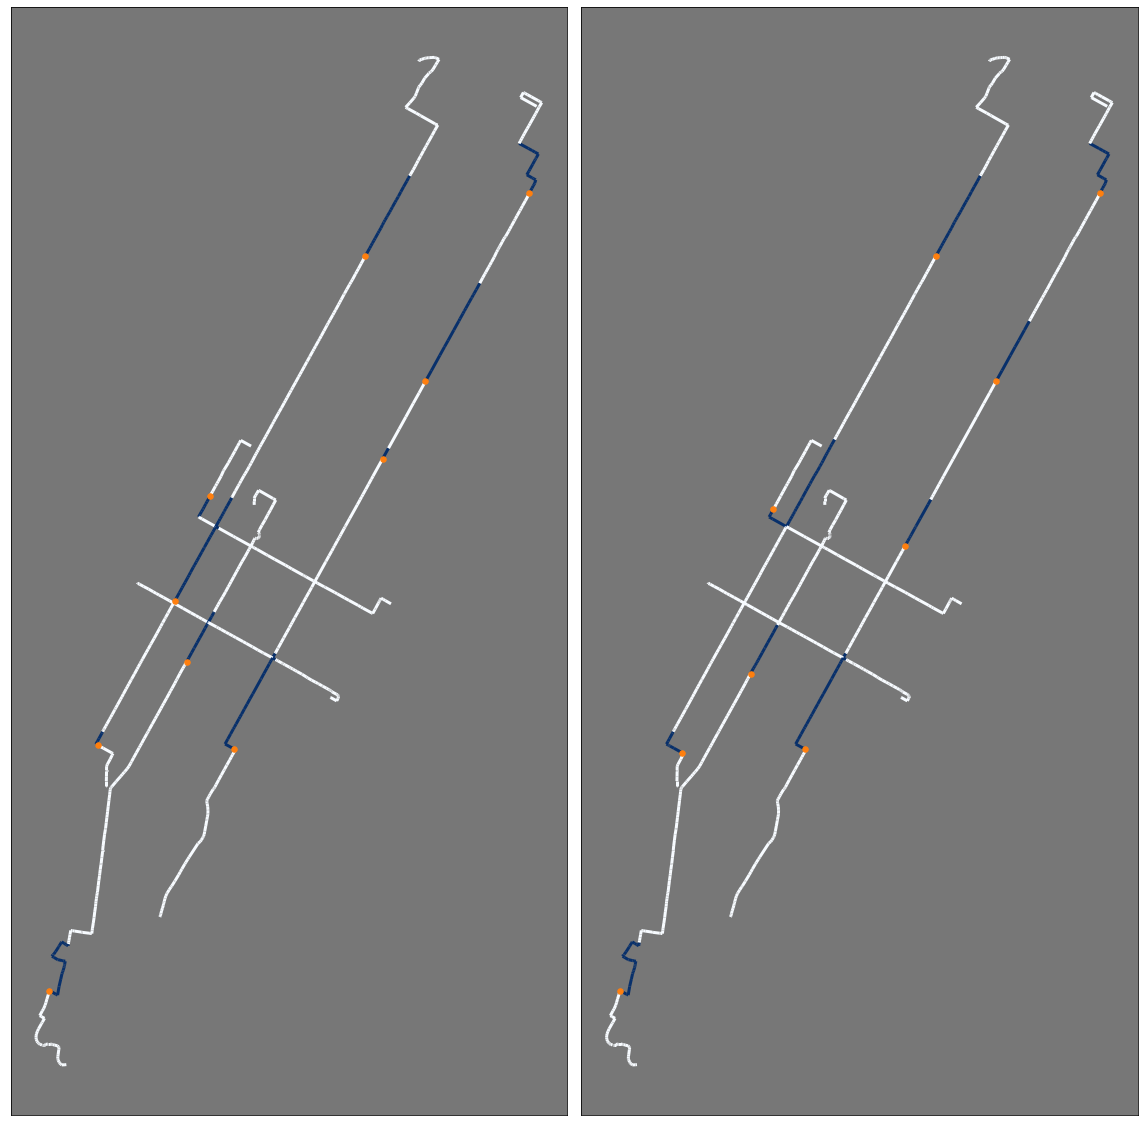

In [64]:
fig, ax = plt.subplots(1, 2, figsize=(16, 16))

power_costs_none = [.2384, .2384, .2384]
power_costs_high = [.0168, .2384, .2384]

test_model('PowerVariation_none', power_costs=power_costs_none, ax=ax[0])
test_model('PowerVariation_high', power_costs=power_costs_high, ax=ax[1])
plt.tight_layout()
plt.show()

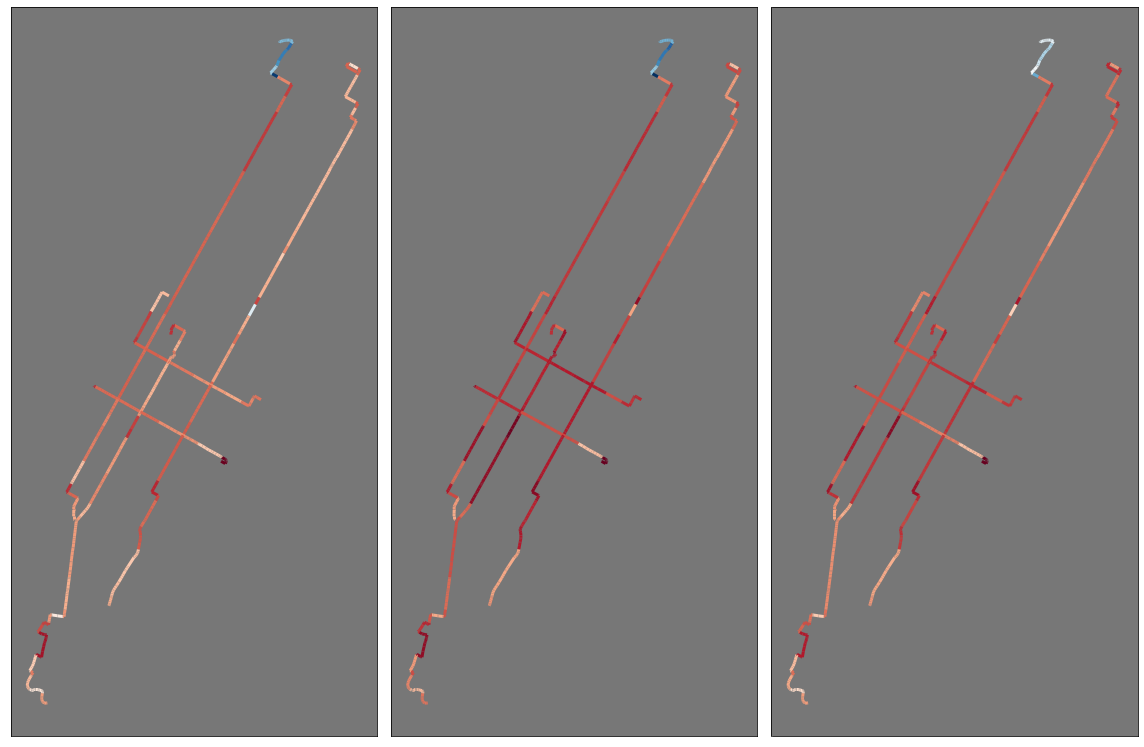

In [44]:
fig, ax = plt.subplots(1, 3, figsize=(16, 16))

vmin = speed_edges_gdf[['speeds_0', 'speeds_1', 'speeds_2']].min().min()
vmax = speed_edges_gdf[['speeds_0', 'speeds_1', 'speeds_2']].max().max()

speed_edges_gdf.plot(ax=ax[0], column='speeds_0', cmap='RdBu', zorder=2, linewidth=3, vmin=vmin, vmax=vmax)
speed_edges_gdf.plot(ax=ax[1], column='speeds_1', cmap='RdBu', zorder=2, linewidth=3, vmin=vmin, vmax=vmax)
speed_edges_gdf.plot(ax=ax[2], column='speeds_2', cmap='RdBu', zorder=2, linewidth=3, vmin=vmin, vmax=vmax)
ax[0].set_facecolor('#777')
ax[1].set_facecolor('#777')
ax[2].set_facecolor('#777')

ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
ax[2].get_xaxis().set_visible(False)
ax[2].get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

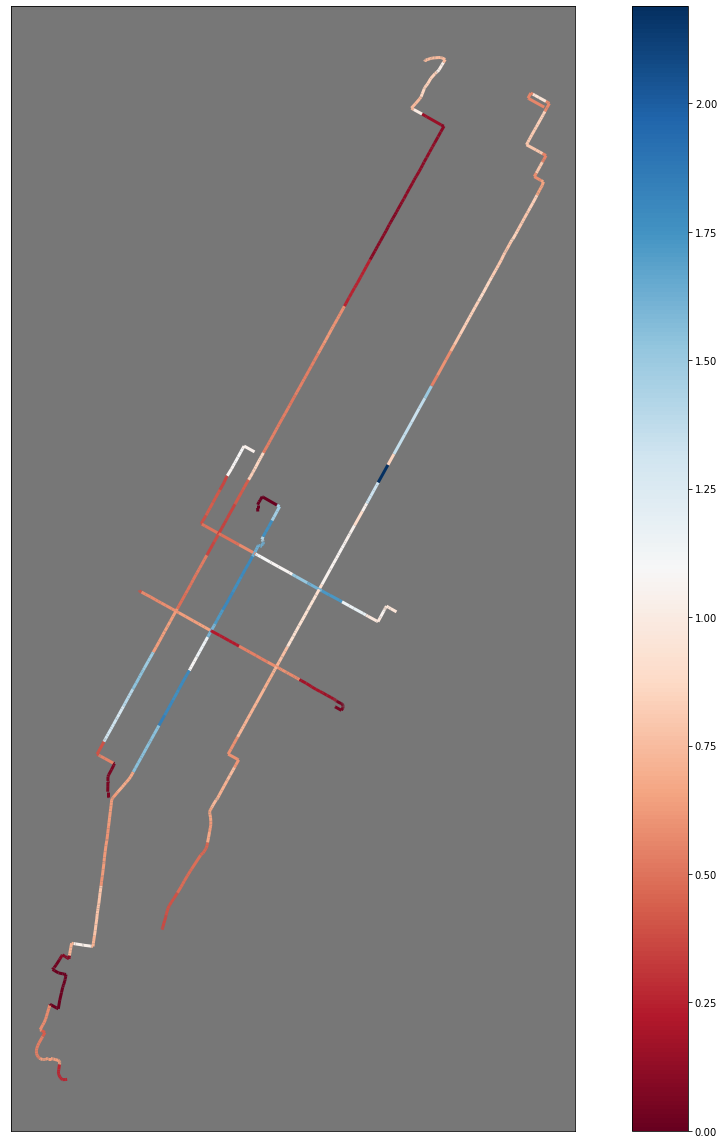

In [52]:
fig, ax = plt.subplots(figsize=(16, 16))

ip_edges_gdf.plot(ax=ax, column='speed_diff', cmap='RdBu', zorder=2, linewidth=3, legend=True)
ax.set_facecolor('#777')

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()